# Import modules

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

In [8]:
data = pd.read_csv("dataset_SCL.csv", low_memory=False)
display(data)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


(array([  504.,  1080.,  2398.,  6320., 12397., 10912.,  8143.,  6029.,
         4446.,  3363.,  2361.,  1167.,  1424.,  1133.,   857.,   678.,
          605.,   446.,   415.,   332.,   284.,   257.,   216.,   127.,
          202.,   172.,   143.,   154.,   116.,    94.,   116.,    93.,
           78.,    98.,    78.,    52.,    55.,    62.,    67.,    56.,
           49.,    62.,    52.,    42.,    39.,    56.,    41.,    24.,
           33.,    34.,    35.,    22.,    26.,    18.,    18.,    24.,
           26.,    21.,    26.,    28.]),
 array([-840., -665., -490., -315., -140.,   35.,  210.,  385.,  560.,
         735.,  910., 1085., 1260., 1435., 1610., 1785., 1960., 2135.,
        2310., 2485., 2660., 2835., 3010., 3185., 3360., 3535., 3710.,
        3885., 4060., 4235., 4410., 4585., 4760., 4935., 5110., 5285.,
        5460., 5635., 5810., 5985., 6160., 6335., 6510., 6685., 6860.,
        7035., 7210., 7385., 7560., 7735., 7910., 8085., 8260., 8435.,
        8610., 8785., 8960.,

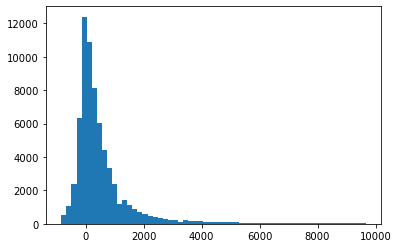

In [33]:
delta_t = pd.to_datetime(data['Fecha-O'])-pd.to_datetime(data['Fecha-I'])
plt.hist([i.total_seconds() for i in delta_t], bins = 60)

In [26]:
delta_t

0         0 days 00:03:00
1         0 days 00:09:00
2         0 days 00:09:00
3         0 days 00:03:00
4       -1 days +23:58:00
               ...       
68201     0 days 00:46:00
68202     0 days 00:16:00
68203     0 days 00:40:00
68204     0 days 00:13:00
68205     0 days 00:09:00
Length: 68206, dtype: timedelta64[ns]

# Introduction

In [ ]:
temporada_alta
dif_min
atraso_15
periodo_dia